In [184]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

## 定义模型

#### 方法一

In [189]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3)
        self.conv3 = nn.Conv2d(128, 256,3)
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(2,2))
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(2,2))
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,(2,2))
        
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


#### 方法二

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,3,2),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(inplace = True),
            nn.Linear(256*12*12, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 2)
        )
    def forward(x):
        return self.model(x)
    
net = Net()
print(net)

Net(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Linear(in_features=36864, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 载入数据

In [88]:
from __future__ import print_function, division

import torchvision
from torchvision import datasets, models, transforms
import torch
from torch.optim import lr_scheduler
import torch.optim as optim


In [129]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),#随机裁剪
        transforms.RandomHorizontalFlip(),#左右翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transform[x])
                        for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                           shuffle = True, num_workers = 4)
                        for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 增强数据可视化

In [182]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

In [155]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

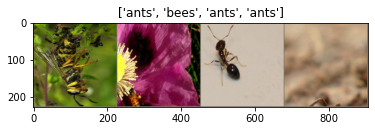

In [183]:
imshow(out, title = [class_names[x] for x in classes])

## 训练模型

In [1]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_correct = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
#                     print('outputs:',outputs)
#                     print('labels:',labels)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(pred == labels.data)
            if phase == 'train':
                scheduler.step()
        epoch_loss = running_loss/dataset_sizes[phase]
        epoch_acc = running_correct.double()/dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [194]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

cnn_model = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
val Loss: 0.6971 Acc:0.4575

Epoch 1/24
----------
val Loss: 0.6836 Acc:0.5948

Epoch 2/24
----------
val Loss: 0.7028 Acc:0.4902

Epoch 3/24
----------
val Loss: 0.6799 Acc:0.5621

Epoch 4/24
----------
val Loss: 0.6825 Acc:0.5163

Epoch 5/24
----------
val Loss: 0.6906 Acc:0.5229

Epoch 6/24
----------
val Loss: 0.6712 Acc:0.5686

Epoch 7/24
----------
val Loss: 0.6729 Acc:0.5294

Epoch 8/24
----------
val Loss: 0.6739 Acc:0.5490

Epoch 9/24
----------
val Loss: 0.6673 Acc:0.5621

Epoch 10/24
----------
val Loss: 0.6631 Acc:0.5752

Epoch 11/24
----------
val Loss: 0.6724 Acc:0.5882

Epoch 12/24
----------
val Loss: 0.6722 Acc:0.5686

Epoch 13/24
----------
val Loss: 0.6613 Acc:0.5752

Epoch 14/24
----------
val Loss: 0.6616 Acc:0.5686

Epoch 15/24
----------
val Loss: 0.6622 Acc:0.5817

Epoch 16/24
----------
val Loss: 0.6628 Acc:0.5882

Epoch 17/24
----------
val Loss: 0.6627 Acc:0.5882

Epoch 18/24
----------
val Loss: 0.6629 Acc:0.5882

Epoch 19/24
----------

In [201]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

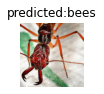

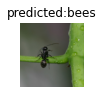

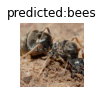

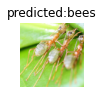

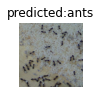

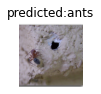

In [202]:
visualize_model(cnn_model)

## 使用预训练模型

In [206]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [208]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
val Loss: 0.2159 Acc:0.9542

Epoch 1/24
----------
val Loss: 0.2575 Acc:0.9216

Epoch 2/24
----------
val Loss: 0.2662 Acc:0.9085

Epoch 3/24
----------
val Loss: 0.2582 Acc:0.8889

Epoch 4/24
----------
val Loss: 0.2026 Acc:0.9542

Epoch 5/24
----------
val Loss: 0.2204 Acc:0.9281

Epoch 6/24
----------
val Loss: 0.2159 Acc:0.9150

Epoch 7/24
----------
val Loss: 0.1807 Acc:0.9542

Epoch 8/24
----------
val Loss: 0.1924 Acc:0.9477

Epoch 9/24
----------
val Loss: 0.2145 Acc:0.9346

Epoch 10/24
----------
val Loss: 0.2159 Acc:0.9346

Epoch 11/24
----------
val Loss: 0.2083 Acc:0.9412

Epoch 12/24
----------
val Loss: 0.1818 Acc:0.9477

Epoch 13/24
----------
val Loss: 0.1978 Acc:0.9412

Epoch 14/24
----------
val Loss: 0.2506 Acc:0.9216

Epoch 15/24
----------
val Loss: 0.1851 Acc:0.9477

Epoch 16/24
----------
val Loss: 0.1698 Acc:0.9608

Epoch 17/24
----------
val Loss: 0.2119 Acc:0.9346

Epoch 18/24
----------
val Loss: 0.1851 Acc:0.9542

Epoch 19/24
----------

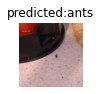

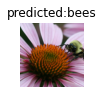

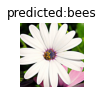

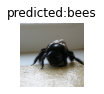

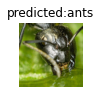

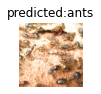

In [209]:
visualize_model(model_ft)
plt.ioff()
plt.show()